# Other Computer Vision Problems

* In previous chapter we learned how to pick the right learning rate, and how the number of epochs may effect the accuarcy of our model.
* In this chapter we will learn about two other types of computer vision problem: 
   - Multi-label classification: is when we want to predict one or more label per image (or even none)
   - Regression: is when the label is a quantative number(s) rather than a categories 
* **In the process will study more deeply the output activations, targets, and loss functions in deep learning models.**

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 13.1 MB/s 
     |████████████████████████████████| 1.3 MB 27.4 MB/s 
     |████████████████████████████████| 5.3 MB 41.8 MB/s 
     |████████████████████████████████| 441 kB 48.6 MB/s 
     |████████████████████████████████| 1.6 MB 23.9 MB/s 
     |████████████████████████████████| 115 kB 50.9 MB/s 
     |████████████████████████████████| 163 kB 42.7 MB/s 
     |████████████████████████████████| 212 kB 18.8 MB/s 
     |████████████████████████████████| 127 kB 52.8 MB/s 
     |████████████████████████████████| 115 kB 48.9 MB/s 
     |████████████████████████████████| 7.6 MB 45.9 MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

## Multi-Label Classification

* As we briefly explain, multi-label classfication is when we predict more than category for one image or even zero category.
* In fact the bear classfier we built earlier is a good example of multi-label calssification , the only exception is that our model doesn't have the feature of returning zero class if the model isn't confidently sure about neither of the classes
* In practice it is more likely to see an images that match more than 1 categories or zero, but it's rarely to see models being trained for that prorpose.
* First, let's see what a multi-label dataset looks like, then we'll explain how to get it ready for our model. we'll see that the architecture of the model does not change from the last chapter; only the loss function does.

### The Data

* For this chapter we will work with **Pascal Dataset** which provide multi-label categories per image.
- First download the data

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

* This dataset is differente from what we've seen till now, it's not structured by filename or folder, instead comes with **CSV**(Comma-Separated Values) telling us what label is assigned to each image.
    - we will use pandas to see analyze the data

In [4]:
df = pd.read_csv(path/'train.csv')
df

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
...,...,...,...
5006,009954.jpg,horse person,True
5007,009955.jpg,boat,True
5008,009958.jpg,person bicycle,True
5009,009959.jpg,car,False


###Constructing a DataBlock

* Now we will go through the steps of creating `DataLoaders` objects from `DataFrame`.
* The easiest way is to use `DataBlock` **API**.
* But first we need to define each of these concepts:
    - `Dataset`: A collection that return a tuple with dependent and independent variales when we index into it ( in this case dataframe)
    - `DataLoader`: An iterator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch of dependent variables
* On the top of these, fastai provides two classes for bringing training and validation set together: 
    - `Datasets`: a class that contains training `dataset` and validation `dataset`
    - `DataLoaders`: a class that contains training `DataLoader` and validation `DataLoader`     


* Let's create a `DataBlock` with no parameters, then create `Datasets` object from in by passing the actual `DataFrame` we will use `df`

In [5]:
dblock = DataBlock()

In [6]:
# create datasets objects
dsets = dblock.datasets(df)

* By default the dataset is randomly splited to train and validation 80%/20%

In [7]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

* If we call the first item from one of the `Datasets` it return a row of DataFrame twice, assuming that we have two things: input and target, which we will build later.

In [8]:
x, y = dsets.train[0]
x, y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

* The dependent variable is the image name, and the independent variable is the label,  so let's grab them

In [9]:
x['fname'], x['labels']

('008663.jpg', 'car person')

* The goal here is to tell Datablock how identify the `x`'s and `y`'s of the dataset.
* We will use `get_x` and `get_y` functions

In [10]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

* The problem with `lambdas` is cannot be saved when we create a learner, this is why it's better to avoid them.

In [11]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock =  DataBlock(get_x= get_x, get_y=get_y)
dsets= dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [12]:
from PIL import Image

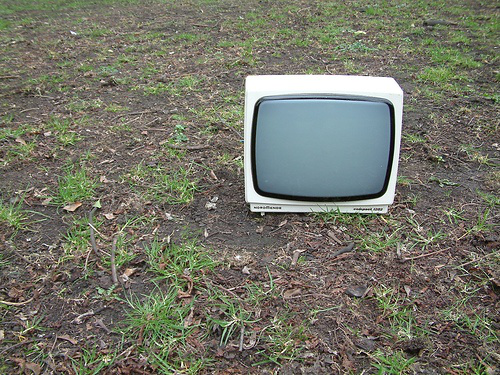

In [13]:
Image.open(path/'train'/'002549.jpg')

* In order to open an image we need the path
* As we know some images has more the one label, that why we need to split them by space.
* Let's recreate the datablock by adding this 2 things (path, split)

In [14]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock =  DataBlock(get_x= get_x, get_y=get_y)
dsets= dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002844.jpg'), ['train'])

* Now we can open the image just by calling the `[0]` of the index of that item in dataset

* To open image and do the conversion to tensors, we will use block types to provide us with set of transforms: `ImageBlock` and `MultiCategoryBlock`
   - we used `ImageBlock` before, it open the image from the path
   - before we used `CategoryBlock` which cannot be used here, because it returned a single integer, but here we have multiple labels for each image, thats why we need `MultiCategoryBlock`

In [16]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y)
dsets= dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [17]:
dsets.train[0][1]

TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

* As we see the list of categories contains zeros and one 1.
* The zeros represent all the other categories that doesn't match the image, and obviously the 1 represent the label
* This is known as **One-Hot Encoding**
* Let's see which category represent this particular image by using `toch.where`

In [18]:
idxs = torch.where(dsets.train[77][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['person','sofa']

* Till we use the randome splitter provided by default, instead of using the `is_valid` which can be used as splitter

In [19]:
df.is_valid

0        True
1        True
2        True
3       False
4        True
        ...  
5006     True
5007     True
5008     True
5009    False
5010    False
Name: is_valid, Length: 5011, dtype: bool

In [20]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [21]:
len(dsets.train), len(dsets.valid)

(2501, 2510)

* One last we have to do before creating our dataloaders, is to make sure that all images are the same size by using `RandomResizeCrop`

In [22]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

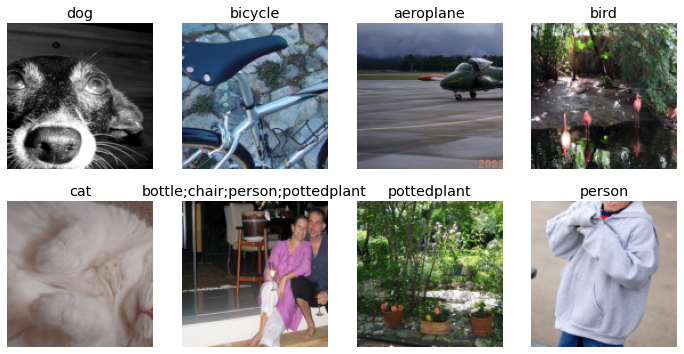

In [23]:
dls.show_batch(nrows=2, ncols=4)

### Binary Cross-Entropy

* Now we need to create a Learner, we know that learner is defined by 4 things: 
    - model (resenet18)
    - dataloaders, we already created it
    - Optimizer (SGD)
    - loss-function: we need to make sure that we create a suitable loss function for this type of model.First we create a learner and look at its activations

In [24]:
learn = vision_learner(dls, resnet18)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

* Now we bring one batch and deconstruct it with `x` and `y`, then call the model as function by passing the independent variable as parameter, which will return activations.

In [25]:
x, y= to_cpu(dls.train.one_batch())
activs= learn.model(x)
activs.shape

torch.Size([64, 20])

In [26]:
activs[2]

TensorBase([ 2.1179, -0.0294,  0.7001, -0.3637,  0.9945,  3.5996, -3.0180,  1.5298,  0.8906, -0.3150,  0.7787,  0.9151,  3.0681, -4.6584,  1.9598, -0.6030, -1.8170,  2.2310,  1.1888, -0.0595],
           grad_fn=<AliasBackward0>)

* As we see here the activations aren't yet scaled between 0 and 1, so we need to use `Sigmoid()` to do that.
* The loss we will use here is similar to the one we used in mnist dataset: `mnist_loss`, the only different is we will add `log()`.

In [27]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

* Because we have a one-hot-encoded dependent variable, we can't use `nll_loss` or `softmax`.
* Softmax make all predictions sum to 1, and push one activation to be much larger that the others, due to use of `exp`, but in our case we may have more than one target we need to predict, so the sum of all activations to 1 will be am issue here
* In other hand `nll_loss` as we saw returns the value of one activation, the that is corresponding to the single label. but we have have multiple labels!
* One other benefit of this function `binary_cross_entropy` is that it uses the `broadcasting` technic, by apllying the logic `-torch.where(targets==1, 1-inputs, inputs)` to all labels.
     - it's like asking each image: is that a cat?, is that a chair? is that a person?.. and after each question calculating the different between the predicted value and the actual value and return it as loss.

* Pytorch provide us with functions and modules that do exactly the same.
* `F.binary_cross_entropy` and `nn.BCELoss` calculate the cross-enropy on one-hot-encoded target, but without inculding the `sigmoid()`
* The built-in `sigmoid()` version of these two are: `F.binary_cross_entropy_with_logits` and `nn.BCEWithLogitsLoss`.
* So the equivalent built-in function to our `binary_cross_entropy` is **`nn.BCEWithLogitsLoss`**

In [28]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0342, grad_fn=<AliasBackward0>)

* Although we don't need to tell fastai to use this function as a loss, because it will pick `nn.BCEWithLogitsLoss()` automatically since we have multiple category labels.
___

* In this model we will use slightly different accuracy function.
* The previous accuracy function compare our outputs with the single target, but since we have multiple targets, we need to aplly it differently.
* After we apply sigmoid to our activations, we need decide which are 1 and which are 0, the best way is to create some threshold, all values above it are 1's, else == 0.


In [29]:
def accuracy_multi(inp, trg, thresh=0.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==trg.bool()).float().mean()

* This function use the default threshold value, if we want to adjust this value within the same function, we will use a function in Python called `partial`
* It allows us to *bind* a function with some arguments or keyword arguments, making a new version of that function that, whenever it is called, always includes those arguments

In [30]:
# partial function
def say_hello(name, say_what='hello'): return f'{say_what} {name}'
say_hello('Ismail'), say_hello('Ismail', 'hola')

('hello Ismail', 'hola Ismail')

In [31]:
# we can switch to another version of this function by calling partial
f = partial(say_hello, say_what='Guten Tag')
f('Salim'), f('Karim!')

('Guten Tag Salim', 'Guten Tag Karim!')

* Now we can train our model as usual, we pick here `0.2` as threshold

In [32]:
learn =  vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr= 3e-3, freeze_epochs=4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.943426,0.692230,0.235896,00:39
1,0.823277,0.564228,0.285199,00:31
2,0.604020,0.199862,0.827908,00:32
3,0.359526,0.124002,0.944323,00:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.131472,0.116906,0.944203,00:31
1,0.116399,0.106551,0.951096,00:31
2,0.096168,0.104706,0.951116,00:31


* Picking the threshold is so important, if we pick too low we'll often be failing to select correctly labeled objects, and if we pick to high we end up selecting only the objects that the model is strongly confident about.
* We will grab all predictions and target using `get_preds`, then we will try few values for the `thresh` and see what get us the highest value.

In [33]:
preds, targs= learn.get_preds()

* The we can call the metrics directly, we just need to deactivate the sigmoid since it already apllied by default by `get_preds` on activations.

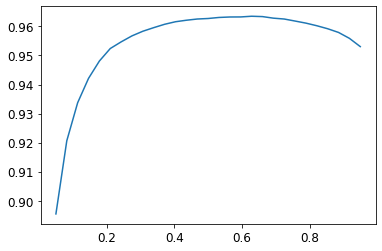

In [34]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

* According to this plot, the accuracy reach its highest when the `thresh` at `0.6`
____

## Regression

* We usualy think of deep learnig as couple of fields, each has its own architecture, problems, datatype.. for example there's NLP, Vision, Regression, Tabular.
* But the main difference among models used in these fields are basically the difference between dependent and independent variables used in those models, along side with its loss function.That means that there's really a far wider array of models than just the simple domain-based split.
   - we can use text to generate image or vice versa, we can use continous values to predict videos/images/ texts.. 
* Here we will build a **Regression Image** model
   - the dependent variables are images
   - while the independent variables are float values

### Assemble the Data

* We will use the  [Biwi Kinect Head Pose dataset](https://icu.ee.ethz.ch/research/datsets.html) for this section. We'll begin by downloading the dataset as usual:

In [35]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [36]:
Path.BASE_PATH = path

In [37]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

* There are 24 directories numbered from 01 to 24 (they correspond to the different people photographed), and a corresponding *.obj* file for each (we won't need them here). Let's take a look inside one of these directories:

In [38]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

* Inside the subdirectories, we have different frames, each of them come with an image (*\_rgb.jpg*) and a pose file (*\_pose.txt*). We can easily get all the image files recursively with `get_image_files`, then write a function that converts an image filename to its associated pose file:

In [39]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('20/frame_00388_pose.txt')

In [40]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

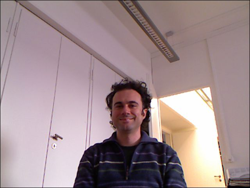

In [41]:
im.to_thumb(250)

*  The Biwi dataset website used to explain the format of the pose text file associated with each image, which shows the location of the center of the head. The details of this aren't important for our purposes, so we'll just show the function we use to extract the head center point:

In [42]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])


* This function return the coordinate of the center of the head of each image, so we can pass it as the `get_y` to DataBlock since it represent the independent variable for each image

In [43]:
get_ctr(img_files[0])

tensor([343.6303, 276.7759])

* This dataset contains images of many person, each one has multiple images, so we can't just randomly split the dataset, because we need the model to generelize on new people/images, and training the model on image of a person, and validate the results on a training set that contains images of the same person, will definitively cause **Overfitting**
* Instead what we do in this case, is to take all images that belong to one person, and define them as validation set.

In [44]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320)))

* As we see here we use `PointBlock`, this is what fastai use to coordinate data (tensor with 2 values)
* For the splitting as we said before we took one person's images `13` and put the all into validation dataset.
* We use `aug_transforms` as transformers

* Before doing any modeling, we should look at our data to confirm it seems okay:

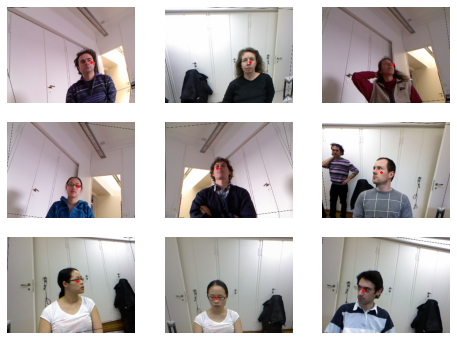

In [45]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [46]:
xb, yb= dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

* `xb` shape is `[64,3,240,320]`: 
    - `64` is the number of items in each mini-batch
    - `3` represent number of channels, which in this case colors
    - `240*320` are the pixels of the image

### Training a Model

* Here we create learner with help of `vision_learner` we pass to it: 
   - `dls`
   - `resnet18`
   - `y_range()`: this function define the range of our targets. In fastai this function is implemented using the `sigmoid_range`

In [47]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [48]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


* This is set as the final layer of the model

* Note that we didn't define the loss function, but we already know that fastai will pick the right loss function for us depend on the type of data/model 

In [49]:
dls.loss_func

FlattenedLoss of MSELoss()

* Fastai picked `MSELoss` which stands for mean square error, which make sense since we have a regression problem.
* But in case we want different loss we can pass it to `vision_learner`  by using `loss_func` parameter.
* In this type of model, we could pick the loss as metric we just need to take the square root of it)
* Now we need to pick a `learning rate`

SuggestedLRs(valley=0.0020892962347716093)

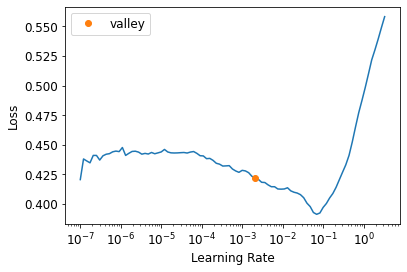

In [50]:
learn.lr_find()

* Then we will try `0.002` as learning rate

In [51]:
lr = 0.002
learn.fine_tune(3, lr)


epoch,train_loss,valid_loss,time
0,0.137417,0.008638,02:04


epoch,train_loss,valid_loss,time
0,0.009691,0.000932,02:10
1,0.003397,0.000595,02:10
2,0.002397,0.000345,02:10


In [52]:
loss = (0.005764+0.001309+0.000556+0.000316)/4
loss

0.00198625

In [53]:
metric_err_rate = round(math.sqrt(0.002), 4)
metric_err_rate

0.0447

* The accuracy of the model `96%` which is good. So by using a computer vision model and with transfer learning technics we manage to solve a regression problem with accuracy of 96%.

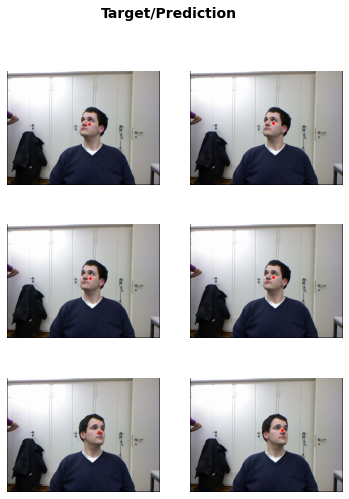

In [54]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))